In [34]:
import galstreams 
mws = galstreams.MWStreams(verbose=False, implement_Off=True)

Initializing galstreams library from master_log... 


In [90]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import stream_analysis as sa
import gcs 
from gcs import path_handler as ph
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from astropy import units as u
import astropy.coordinates as coord

In [ ]:
def extract_to_tail_coordinates(orbitpath,streampath,montecarlokey,internal_dynamics,NP):
    """
    Here to extract the raw data and transform the stream to tail coordinates in one go
    """
    time_of_interest,nDynTimes=0,2
    tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv = gcs.extractors.GCOrbits.extract_whole_orbit(orbitpath,montecarlokey=montecarlokey)
    tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv=sa.tailCoordinates.filter_orbit_by_dynamical_time(tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,time_of_interest,nDynTimes)
    _,xp,yp,zp,vxp,vyp,vzp = gcs.extractors.Stream.extract_old_streams(streampath,internal_dynamics=internal_dynamics,montecarlokey=montecarlokey,NP=NP)
    xT,yT,zT,vxT,vyT,vzT,_ = sa.tailCoordinates.transform_from_galactico_centric_to_tail_coordinates(xp,yp,zp,vxp,vyp,vzp,tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,t0=time_of_interest)
    return xT,yT,zT,vxT,vyT,vzT

In [7]:
## Set the global variables
GCname = "Pal5"
NP = int(1e5)
internal_dynamics = "isotropic-plummer"
montecarlokey="monte-carlo-009"

streamPotential="pouliasis2017pii-GCNBody"
orbitPotential="pouliasis2017pii-GCNBody"
# streamPotentials = ["pouliasis2017pii-GCNBody","pouliasis2017pii-NGC2808","pouliasis2017pii-NGC7078","pouliasis2017pii-NGC104","pouliasis2017pii"]
# orbitPotentials = ["pouliasis2017pii-GCNBody","pouliasis2017pii-GCNBody","pouliasis2017pii-GCNBody","pouliasis2017pii-GCNBody","pouliasis2017pii"]


In [10]:
# load the path names
streampath = ph.old_streams(MWpotential=streamPotential, GCname=GCname,montecarlokey=montecarlokey,NP=NP) 
orbitpath = ph.GC_orbits(MWpotential=orbitPotential, GCname=GCname) 


In [11]:
tailcoordinates = extract_to_tail_coordinates(orbitpath,streampath,montecarlokey,internal_dynamics,NP)

In [ ]:
# make the 2D scatter density maps
xT,yT,zT,vxT,vyT,vzT = tailcoordinates
XX,YY,H=sa.plotters.binned_density.short_cut(NP,xT,yT,[-10,10],[-1,1])
H=sa.plotters.binned_density.normalize_density_by_particle_number(H,NP)

In [18]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

In [23]:
# the structre of the plot 
def set_up_plot(Nrows):
    fig=plt.figure(figsize=(10,1.5*Nrows + 1))
    gs=gridspec.GridSpec(Nrows,2, width_ratios=[1,0.01],hspace=0.5,wspace=0.05)
    axis=[]
    if Nrows >=3:
        cbar = fig.add_subplot(gs[1:Nrows-1,1])
    else:
        cbar = fig.add_subplot(gs[:,1])
    for i in range(Nrows):
        axis.append(fig.add_subplot(gs[i,0]))
    return fig,axis,cbar

In [51]:
def MWreferenceframe():
    from astropy import coordinates
    from astropy import units as u
    import yaml 
    absolute_path_to_frame = "/home/sferrone/gcs/scrapnotebooks/MWrefframe001.yaml"
    with open(absolute_path_to_frame, 'r') as frame:
        try:
            frame_data = yaml.safe_load(frame)
        except yaml.YAMLError as exc:
            print(exc)
        galcen_distance=frame_data['value']['galcen_distance']*u.Unit(frame_data['unit']['galcen_distance'])
        z_sun   =   frame_data['value']['z_sun']    *   u.Unit(frame_data['unit']['z_sun'])
        vSun    =   frame_data['value']['vSun']     *   u.Unit(frame_data['unit']['vSun'])
        vLSR    =   frame_data['value']['vLSR']     *   u.Unit(frame_data['unit']['vLSR'])
    return coordinates.Galactocentric(galcen_distance = galcen_distance, galcen_v_sun=vLSR+vSun, z_sun=z_sun)

In [52]:
refframe= MWreferenceframe()

In [141]:
tracknames=mws.get_track_names_for_stream('Pal5')
useabletracknames = [tracknames[1],tracknames[2],tracknames[3]] # the first doesn't have distance data
mytrack=mws[useabletracknames[2]].track.transform_to(refframe)
xtrack,ytrack,ztrack = mytrack.cartesian.x.to(u.kpc),mytrack.cartesian.y.to(u.kpc),mytrack.cartesian.z.to(u.kpc)
vxtrack,vytrack,vztrack = mytrack.velocity.d_x.to(u.km/u.s),mytrack.velocity.d_y.to(u.km/u.s),mytrack.velocity.d_z.to(u.km/u.s)

In [ ]:
# dir(mws[useabletracknames[2]].)
midpoint=mws[useabletracknames[2]].mid_point.transform_to(refframe)

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (229.01315826, -0.21075184, 22.5)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0., 0., -0.)>

In [160]:
sa.tailCoordinates.transform_from_galactico_centric_to_tail_coordinates(np.array([xMid.value]),np.array([yMid.value]),np.array([zMid.value]),np.array([vxMid.value]),np.array([vyMid.value]),np.array([vzMid.value]),tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,t0=time_of_interest)

(array([-0.84793843]),
 array([0.54390754]),
 array([0.14489795]),
 array([16.9913245]),
 array([7.33243467]),
 array([6.84035624]),
 array([1264]))

In [161]:
time_of_interest,nDynTimes=0,2
tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv = gcs.extractors.GCOrbits.extract_whole_orbit(orbitpath,montecarlokey=montecarlokey)
tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv=sa.tailCoordinates.filter_orbit_by_dynamical_time(tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,time_of_interest,nDynTimes)
tracknames=mws.get_track_names_for_stream('Pal5')
useabletracknames = [tracknames[1],tracknames[2],tracknames[3]] # the first doesn't have distance data

xTs=[]
yTs=[]
midXs=[]
midYs=[]
for trackname in useabletracknames:
    midpoint=mws[trackname].mid_point.transform_to(refframe)
    mytrack=mws[trackname].track.transform_to(refframe)
    xtrack,ytrack,ztrack = mytrack.cartesian.x.to(u.kpc),mytrack.cartesian.y.to(u.kpc),mytrack.cartesian.z.to(u.kpc)
    vxtrack,vytrack,vztrack = mytrack.velocity.d_x.to(u.km/u.s),mytrack.velocity.d_y.to(u.km/u.s),mytrack.velocity.d_z.to(u.km/u.s)
    xMid,yMid,zMid=midpoint.cartesian.x.to(u.kpc),midpoint.cartesian.y.to(u.kpc),midpoint.cartesian.z.to(u.kpc)
    vxMid,vyMid,vzMid=midpoint.velocity.d_x.to(u.km/u.s),midpoint.velocity.d_y.to(u.km/u.s),midpoint.velocity.d_z.to(u.km/u.s)
    xT,yT,zT,vxT,vyT,vzT,_ = sa.tailCoordinates.transform_from_galactico_centric_to_tail_coordinates(xtrack.value,ytrack.value,ztrack.value,vxtrack.value,vytrack.value,vztrack.value,tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,t0=time_of_interest)
    xTMid,yTMid,_,_,_,_,_ = sa.tailCoordinates.transform_from_galactico_centric_to_tail_coordinates(np.array([xMid.value]),np.array([yMid.value]),np.array([zMid.value]),np.array([vxMid.value]),np.array([vyMid.value]),np.array([vzMid.value]),tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,t0=time_of_interest)
    xTs.append(xT)
    yTs.append(yT)
    midXs.append(xTMid)
    midYs.append(yTMid)
    

In [176]:
cbarlabel=r"Density [$N_p/N$]"
normalScatterProperties = {
    "alpha":0.9, 
    "s":2,
    "cmap":'rainbow',
    "norm":colors.LogNorm(vmin=1e-5, vmax=1e-3)
    }
AXIS={
    "xlabel":"$x_{tail}$ [kpc]",
    "ylabel":"$y_{tail}$ [kpc]",
    "xlim":[-10,10],
    "ylim":[-0.5,0.5],
    "yticks": [0,0.5],
    "xticks": np.arange(-10,11,2),
    "yticks": np.arange(-0.4,0.5,0.2),
}


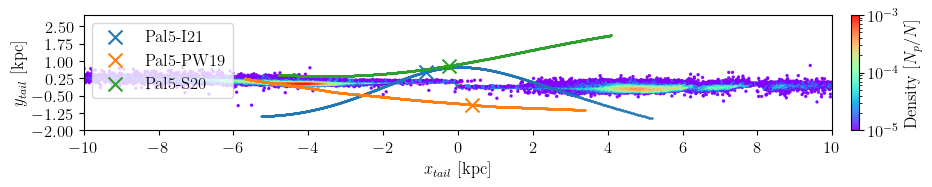

In [ ]:
# fig,axis,cbar = set_up_plot(1)

fig=plt.figure(figsize=(10,1.5))
gs=gridspec.GridSpec(1,2, width_ratios=[1,0.01],hspace=0.5,wspace=0.05)
axis=fig.add_subplot(gs[0,0])
cax=fig.add_subplot(gs[0,1])
i=0
im=axis.scatter(XX,YY,c=H,**normalScatterProperties)
for i in range(len(useabletracknames)):
    trackColor=axis.scatter(xTs[i],yTs[i],s=0.1,label=None)
    axis.scatter(midXs[i],midYs[i],label=useabletracknames[i],s=100,marker='x',color=trackColor.get_facecolor())


AXIS['ylim']=[-1.5,3]
AXIS['yticks'] = np.arange(-2,3,0.75)
axis.legend()
cbar=plt.colorbar(im,cax=cax)
cbar.set_label(cbarlabel);
axis.set(**AXIS);

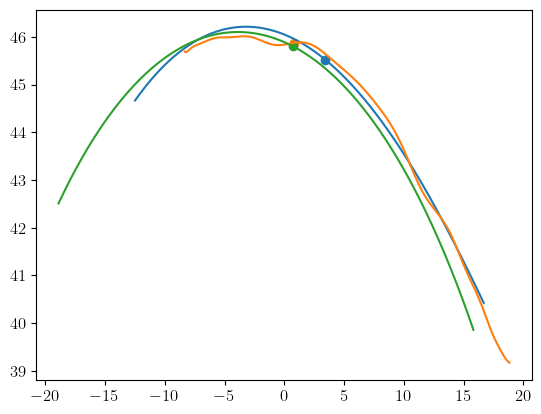

In [166]:
fig,axis=plt.subplots()
for trackname in useabletracknames:
    # plot the track on the sky with its mid point
    mytrack=mws[trackname].track.transform_to('galactic')
    line,=axis.plot(mytrack.l.wrap_at(180*u.deg).to(u.deg),mytrack.b.to(u.deg),label=trackname)
    midpoint=mws[trackname].mid_point.transform_to('galactic')
    axis.scatter(midpoint.l.wrap_at(180*u.deg).to(u.deg),midpoint.b.to(u.deg),c=line.get_color())
